# LAB 1
### Prykhodko Yurii FB-12

#### The purpose of the work
Familiarize yourself with the basics of machine learning and data analysis for problem solving regression, implement methods based on the XGBoost algorithm. Application regularization (Lasso, Elastic Net, etc.).

Dataset [https://www.kaggle.com/datasets/mohansacharya/graduate-admissions/data]

In [1]:
#imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
import xgboost as xgb
from lr import LinearRegression as LR

In [33]:
#read dataframe
df = pd.read_csv('../dataset/grades/Admission_Predict_Ver1.1.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 1 to 500
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 35.2 KB


In [34]:
# as we can see all columns have 500 non-null values, so there is no missing data in dataframe

df.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


In [4]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65


In [5]:
df.duplicated().sum()

#also no duplicates as we can see

np.int64(0)

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')


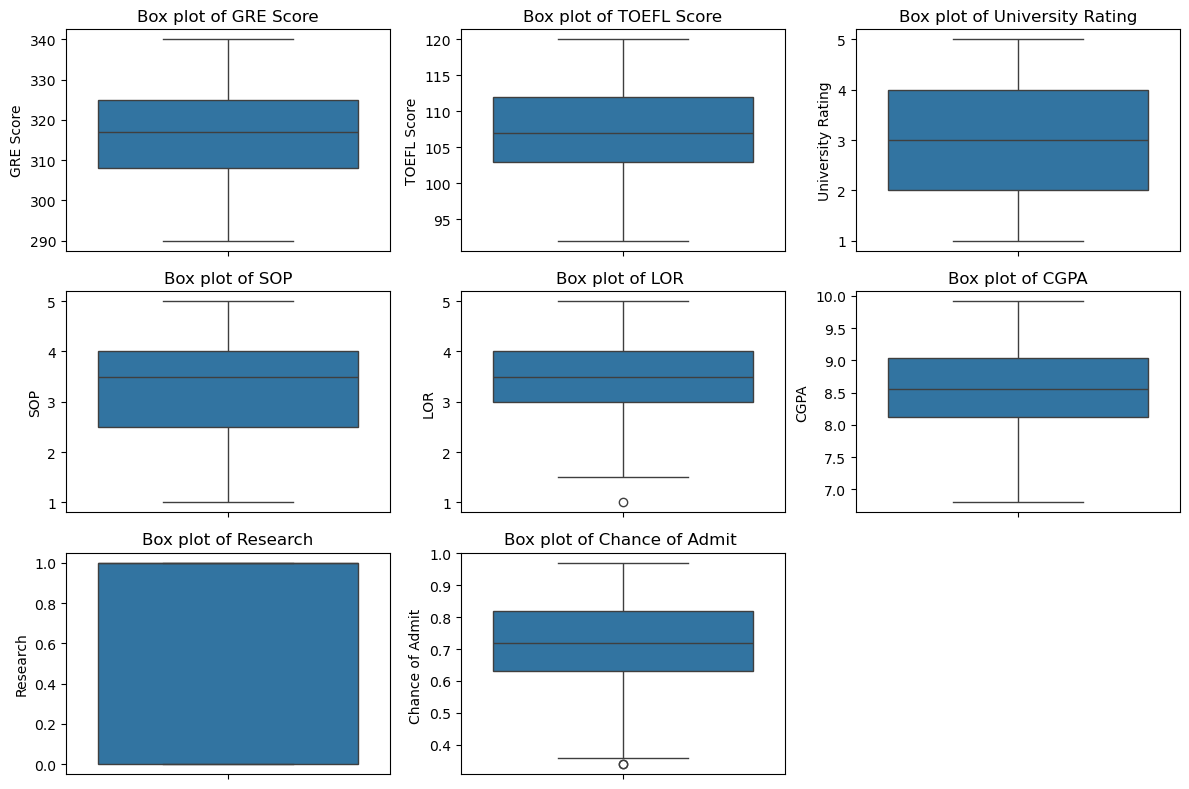

In [6]:
#check outliers
plt.figure(figsize=(12, 8))
for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 3, i)  # 2 rows, 3 columns, index i
    sns.boxplot(y=df[column])
    plt.title(f'Box plot of {column}')
plt.tight_layout()

print(df.columns)

def remove_outliers_iqr(dataframe):
    for column in dataframe.columns:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        dataframe = dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]
    return dataframe

df = remove_outliers_iqr(df)

In [8]:
df.describe()
#got 500 - 497 = 3 removed

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000
mean,316.583501,107.259557,3.122736,3.379276,3.492958,8.582334,0.563380,0.723883
std,11.237070,6.036101,1.140806,0.987070,0.918806,0.601367,0.496466,0.138800
min,290.000000,92.000000,1.000000,1.000000,1.500000,6.800000,0.000000,0.360000
25%,308.000000,103.000000,2.000000,2.500000,3.000000,8.130000,0.000000,0.640000
50%,317.000000,107.000000,3.000000,3.500000,3.500000,8.560000,1.000000,0.720000
75%,325.000000,112.000000,4.000000,4.000000,4.000000,9.040000,1.000000,0.820000
max,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


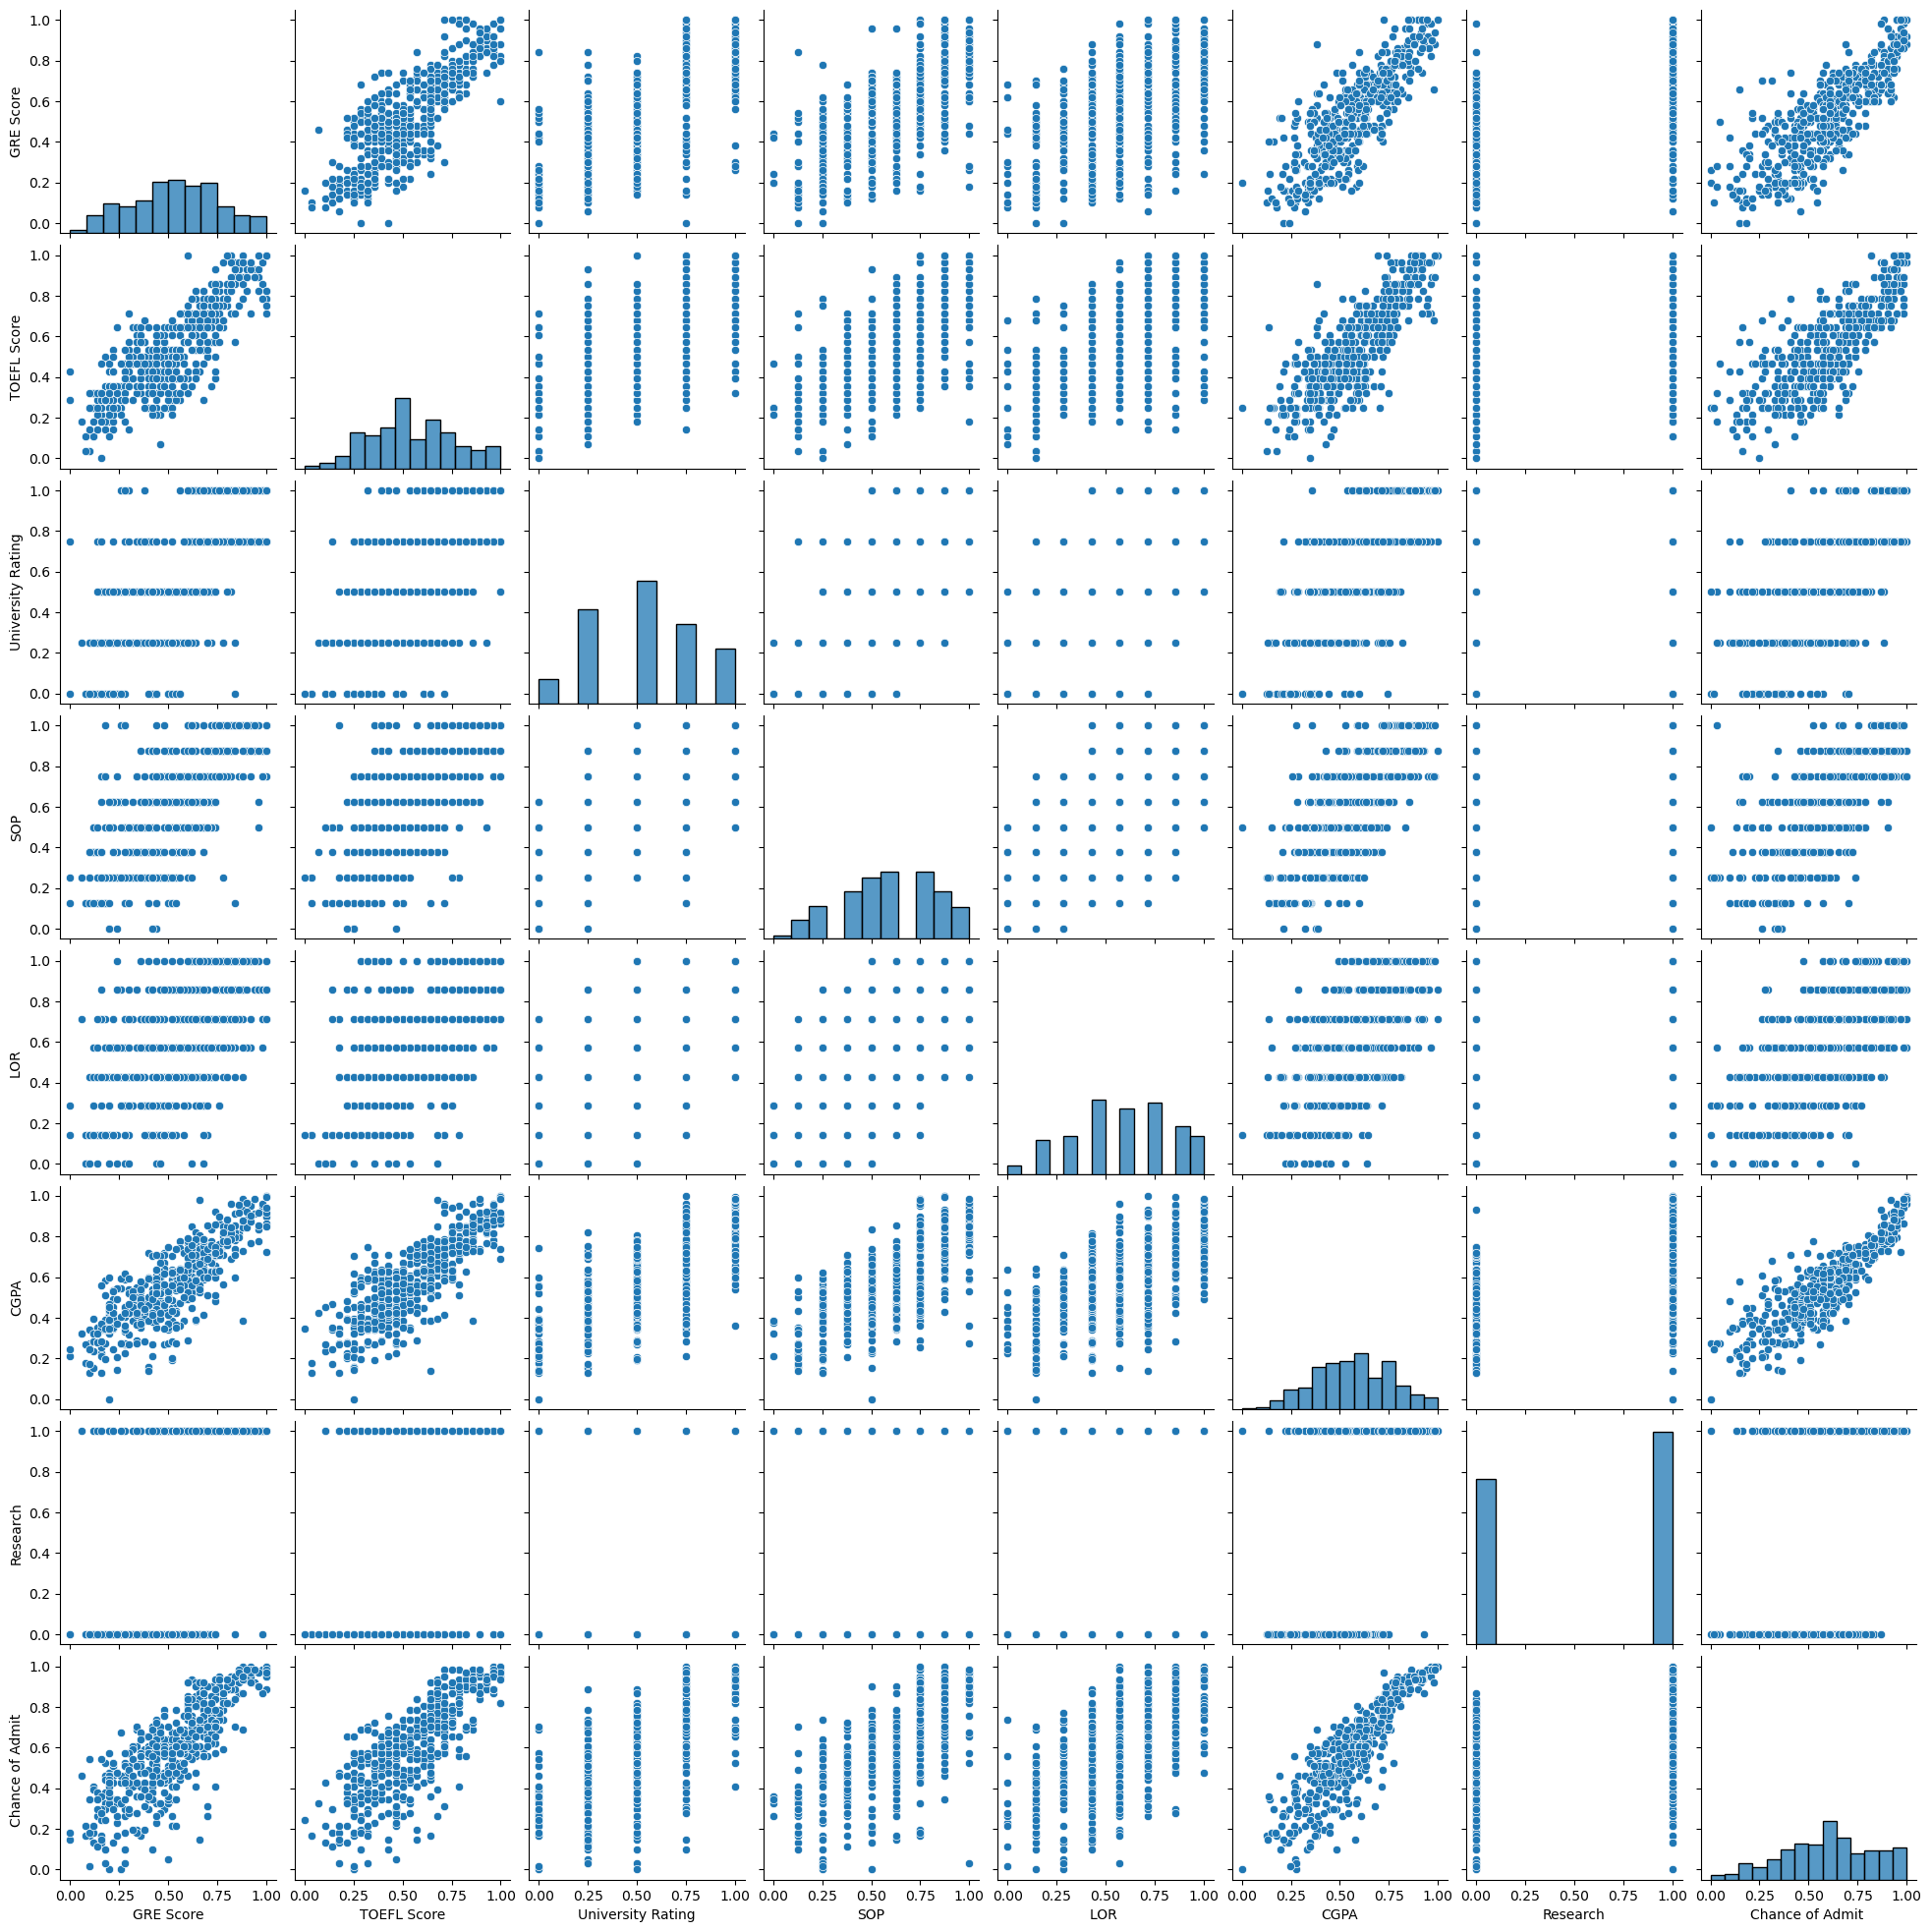

In [31]:
sns.pairplot(df)

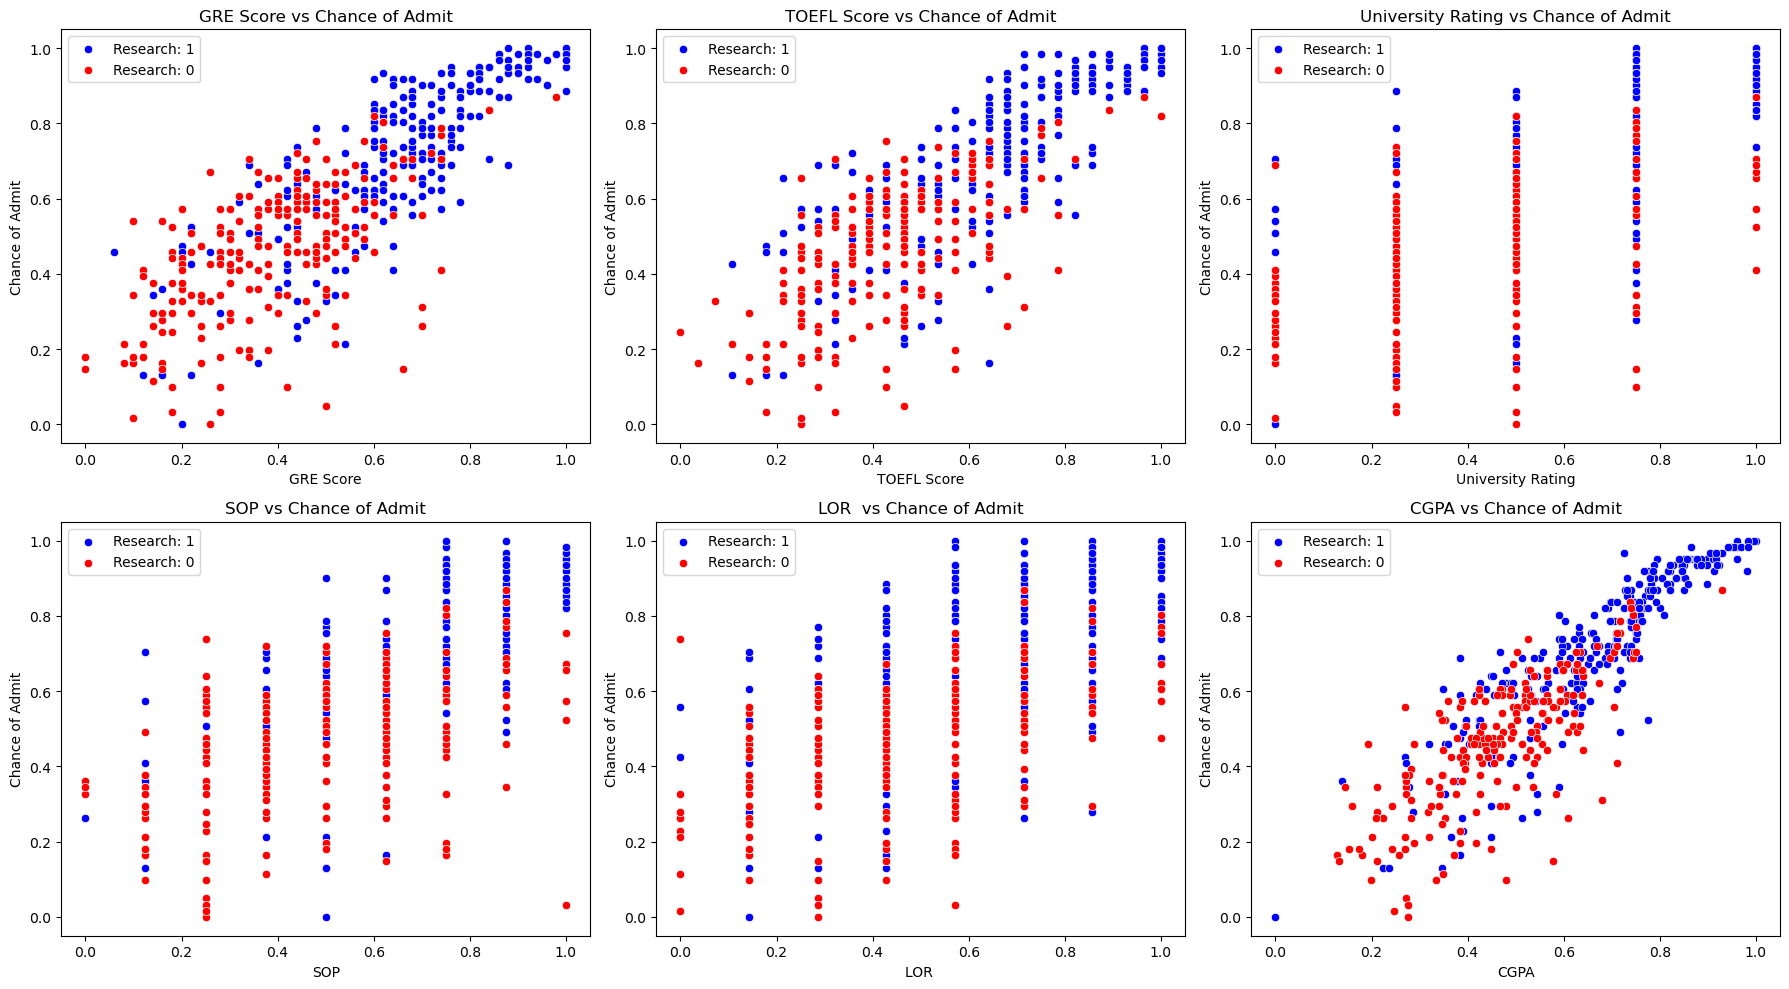

In [29]:
# df = df.drop(['Research'], axis=1)
# df.head()
columns = df.columns
chance_column = 'Chance of Admit '
research_column = 'Research'

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the columns and create scatter plots
for i, col in enumerate(columns[:-2]):
    # Plot points where research = 1 as blue and research = 0 as red
    sns.scatterplot(data=df[df[research_column] == 1], x=col, y=chance_column, ax=axes[i], label='Research: 1', color='blue')
    sns.scatterplot(data=df[df[research_column] == 0], x=col, y=chance_column, ax=axes[i], label='Research: 0', color='red')

    # Set titles and labels
    axes[i].set_title(f'{col} vs Chance of Admit')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Chance of Admit')

# Adjust layout
plt.tight_layout()

In [10]:
# Do the scaling
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,0.94,0.928571,0.75,0.875,0.857143,0.913462,1.0,0.918033
1,0.68,0.535714,0.75,0.750,0.857143,0.663462,1.0,0.655738
2,0.52,0.428571,0.50,0.500,0.571429,0.384615,1.0,0.590164
3,0.64,0.642857,0.50,0.625,0.285714,0.599359,1.0,0.721311
4,0.48,0.392857,0.25,0.250,0.428571,0.451923,0.0,0.475410


<Axes: >

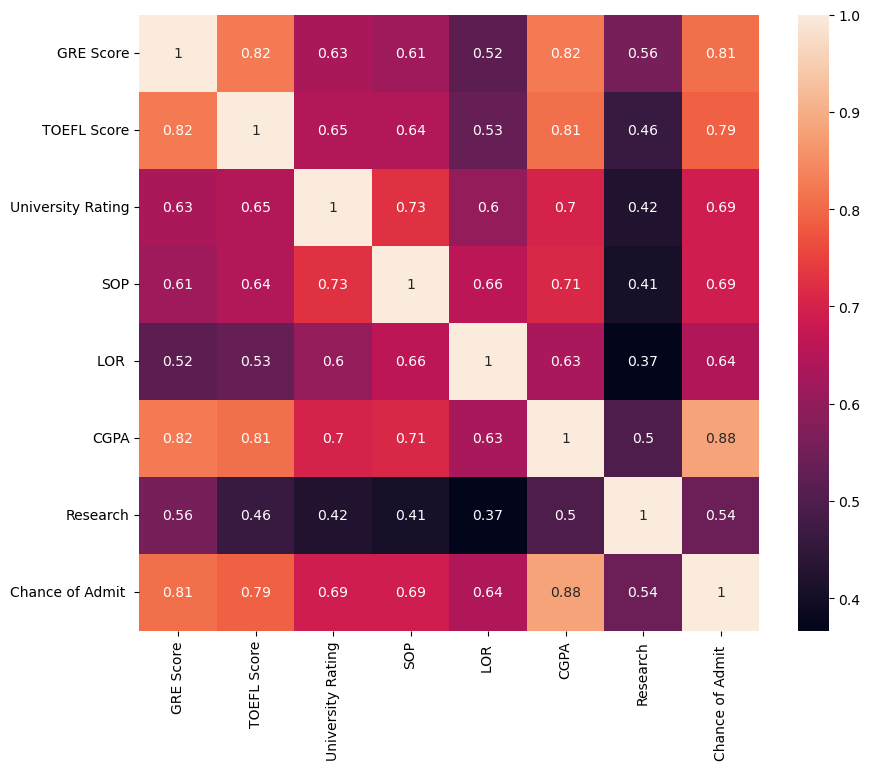

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True)

In [12]:

y_text = 'Chance of Admit '
X = df.drop(y_text, axis=1)
y = df[y_text]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1337) 

In [13]:

sk_model = LinearRegression()
sk_model.fit(train_X, train_y)

LinearRegression()

In [14]:
pred_y = sk_model.predict(test_X)

In [50]:

mape1 = mean_absolute_percentage_error(pred_y, test_y)
r21 = r2_score(pred_y, test_y)
mse1 = mean_squared_error(pred_y, test_y)
mae1 = mean_absolute_error(pred_y, test_y)

print(f"MAPE: {mape1},\n r2: {r21},\n MSE: {mse1},\n MAE: {mae1}")

MAPE: 0.15539844266725494,
 r2: 0.7972081625635881,
 MSE: 0.00960502221868132,
 MAE: 0.07223229903053718


Text(0.5, 0, 'Actual values')

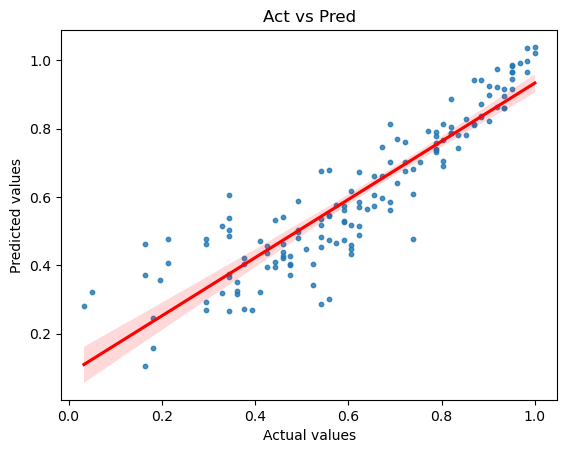

In [16]:


plt.title('Act vs Pred')
fig = sns.regplot(x=test_y, y=pred_y, scatter_kws={'s':10}, line_kws={'color':'r'})
plt.ylabel('Predicted values')
plt.xlabel('Actual values')

In [44]:
xgb_model = xgb.XGBRegressor(
    objective ='reg:squarederror',
    n_estimators=5000,           # Fewer trees to avoid overfitting
    max_depth=3,                # Shallower trees to prevent overfitting
    learning_rate=0.02,         # Smaller learning rate to learn more slowly
    verbosity = 0, 
    seed = 1337
)

In [45]:
xgb_model.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [46]:
xgb_y_pred = xgb_model.predict(test_X)

In [51]:
mape2 = mean_absolute_percentage_error(xgb_y_pred, test_y)
r22 = r2_score(xgb_y_pred, test_y)
mse2 = mean_squared_error(xgb_y_pred, test_y)
mae2 = mean_absolute_error(xgb_y_pred, test_y)

print(f"MAPE: {mape2},\n r2: {r22},\n MSE: {mse2},\n MAE: {mae2}")

MAPE: 0.2463561613901501,
 r2: 0.6841435231822184,
 MSE: 0.015944096475570765,
 MAE: 0.08798045924371058


Text(0.5, 0, 'Actual values')

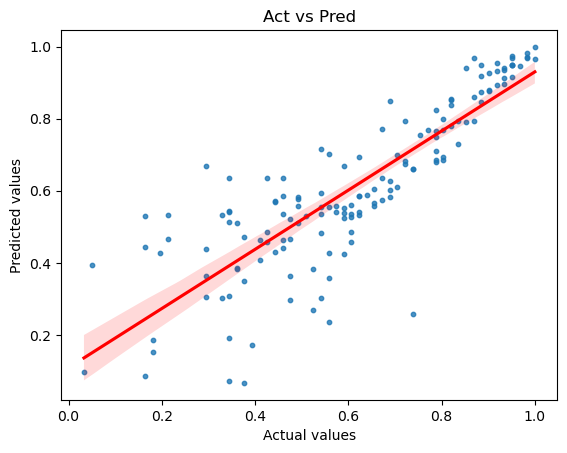

In [48]:
plt.title('Act vs Pred')
fig = sns.regplot(x=test_y, y=xgb_y_pred, scatter_kws={'s':10}, line_kws={'color':'r'})
plt.ylabel('Predicted values')
plt.xlabel('Actual values')

In [22]:
own_model = LR(learning_rate = 0.05, iterations = 5000)
own_model.fit(train_X, train_y)

In [23]:
own_pred = own_model.predict(test_X)

In [52]:
mape3 = mean_absolute_percentage_error(own_pred, test_y)
r23 = r2_score(own_pred, test_y)
mse3 = mean_squared_error(own_pred, test_y)
mae3 = mean_absolute_error(own_pred, test_y)

print(f"MAPE: {mape3},\n r2: {r23},\n MSE: {mse3},\n MAE: {mae3}")

MAPE: 0.15084921489091777,
 r2: 0.7984526490979644,
 MSE: 0.009447240543880176,
 MAE: 0.07029133144856214


Text(0.5, 0, 'Actual values')

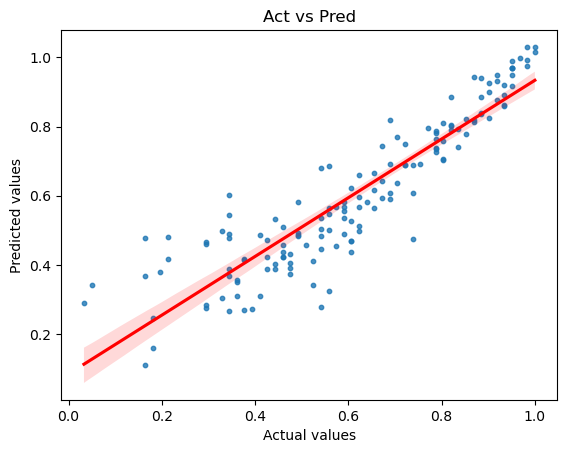

In [25]:
plt.title('Act vs Pred')
fig = sns.regplot(x=test_y, y=own_pred, scatter_kws={'s':10}, line_kws={'color':'r'})
plt.ylabel('Predicted values')
plt.xlabel('Actual values')

##### 

In [49]:
skl_w = sk_model.coef_
skl_b = sk_model.intercept_
print(f"{skl_w = }, {skl_b = }")

own_w = own_model.weights
own_b = own_model.bias
print(f"{own_w = }, {own_b = }")

skl_w = array([1.21202518e-01, 1.09807509e-01, 5.06092747e-02, 1.56990063e-04,
       1.09265160e-01, 6.44051040e-01, 3.80176268e-02]), skl_b = np.float64(-0.009126970638518306)
own_w = array([0.16236641, 0.14049003, 0.05198583, 0.01511653, 0.11472854,
       0.54019827, 0.03776222]), own_b = np.float64(-0.00043584438391260094)


In [53]:
results = pd.DataFrame({
    'Model': ['SKLearn LinealRegression', 'XGBoost', 'Own realization'],
    'R^2': [r21, r22, r23],
    'MSE': [mse1, mse2, mse3],
    'MAE': [mae1, mae2, mae3],
    'MAPE': [mape1, mape2, mape3]
})
print(results)

                      Model       R^2       MSE       MAE      MAPE
0  SKLearn LinealRegression  0.797208  0.009605  0.072232  0.155398
1                   XGBoost  0.684144  0.015944  0.087980  0.246356
2           Own realization  0.798453  0.009447  0.070291  0.150849
